In [9]:
import time
import numpy as np
import wavelets as wl
from scipy import signal
from matplotlib import pyplot as plt

In [10]:
# Downsampling parameters: final resolution = 1000 Hz
fs = 30000.0
final_fs  = 1000.0
ds_factor = fs // final_fs

npoints = 180000
n_samples = np.int(npoints / ds_factor)

In [ ]:
IDs_WT = ['SERT1597', 'SERT1659'] #, 'SERT1678', 'SERT1908', 'SERT1984', 'SERT1985', 'SERT2014']
# IDs_KO = ['SERT1668', 'SERT1665', 'SERT2018', 'SERT2024', 'SERT2013'] 

structures = ['mPFC', 'BLA', 'NAC', 'vHip']
mPFC_WT = dict()

print('Processing WTs...')
clock = time.time()
for ID in IDs_WT:    
    npys_dir = '/home/maspe/filer/SERT/' + ID + '/npys/'
        
    mPFC_WT[ID] = np.load(npys_dir + 'mPFC_epochs.npy', allow_pickle=True)
    print('{} loaded!'.format(ID))
    
    print('Begining downsampling')
    mPFC_WT[ID] = signal.resample(x=mPFC_WT[ID], num=n_samples, axis=1)

    
print('All WTs processed in {:.2f} s.'.format(time.time() - clock))

In [11]:
fs = 1000.0
dt = 1 / fs
time_windows = np.arange(0, 3, dt)
frequencies = np.arange(1, 100, 1)
periods = 1 / (frequencies * dt)
scales = periods / wl.Morlet.fourierwl
n_frequencies = frequencies.shape[0]
time_points = time_windows.shape[0]

In [ ]:
# Reducing epoch
start = 1000
stop = 4000
baseline = 2000

mPFC_SRS = dict()
for key in mPFC_WT.keys():
    clock = time.time()
    print('Morlet wavelet for {} mPFC started!'.format(ID))
    
    n_channels = mPFC_WT[key].shape[0]
    n_epochs = mPFC_WT[key].shape[2]

    mPFC_SRS[key] = np.zeros((n_frequencies, time_points, n_channels, n_epochs))
    for epoch in range(n_epochs):
        
        for channel in range(n_channels): # SRP.shape[0]):
            ### DOCS says data: data in array to transform, length must be power of 2 !!!!
            wavel1 = wl.Morlet(mPFC_WT[key][channel, start:stop, epoch], scales=scales)
            mPFC_SRS[key][:, :, channel, epoch] = wavel1.getnormpower()
            
    print('Transforming to z-score...')        
    baseline_mean = np.mean(mPFC_SRS[key][:, baseline:, :, :], axis=1)
    baseline_sd = np.std(mPFC_SRS[key][:, baseline:, :, :], axis=1)
    mPFC_SRS[key] = (mPFC_SRS[key] - baseline_mean[:, None, :, :]) / baseline_sd[:, None, :, :]
        
    print('Mouse {} Fourier transformed in {:3.2f} s.'.format(ID, time.time() - clock))
        
print('Done!')

In [ ]:
mPFC_mean_SRS = dict()
for key in mPFC_SRS.keys():
    mice_mean_SRS[key] = np.mean(mPFC_SRS[key], axis=(2,3))

In [ ]:
np.save('/home/maspe/filer/SERT/ALL/npys/' + 'SRS.npy', mice_mean_SRS)

In [13]:
npys_dir = '/home/maspe/filer/SERT/ALL/npys/'
mPFC_SRS_WT = np.load(npys_dir + 'SRSs.npy', allow_pickle=True).item()
mPFC_SRS_WT

{'SERT1597': array([[ 0.18532834,  0.18546253,  0.18559654, ...,  0.18492561,
          0.18505986,  0.18519409],
        [-0.14356518, -0.14332966, -0.14308913, ..., -0.14424171,
         -0.14402121, -0.14379567],
        [ 0.00106665,  0.00180742,  0.00255994, ..., -0.00108568,
         -0.00037981,  0.00033761],
        ...,
        [ 0.32875698,  0.33013154,  0.32646247, ...,  0.29346001,
          0.30980568,  0.3218903 ],
        [ 0.32701531,  0.3278015 ,  0.32349878, ...,  0.29300082,
          0.30898905,  0.32065443],
        [ 0.32552742,  0.32578109,  0.32089263, ...,  0.2926101 ,
          0.30830153,  0.31961092]]),
 'SERT1659': array([[ 0.02530654,  0.02539029,  0.02547307, ...,  0.02505061,
          0.02513673,  0.02522208],
        [-0.0269978 , -0.02512538, -0.02323623, ..., -0.03251545,
         -0.03069282, -0.02885362],
        [ 0.09552833,  0.09833301,  0.10115797, ...,  0.08723649,
          0.08998006,  0.09274402],
        ...,
        [ 0.08850708,  0.13778

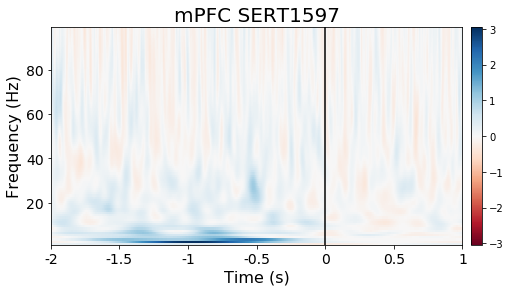

In [19]:
pwr1 = mPFC_SRS_WT['SERT1597']
fmin = min(frequencies)
fmax = max(frequencies)

plt.figure(1, figsize=(10, 4))
plt.clf()

ax1 = plt.subplot2grid((1, 5),(0, 0),colspan=4)
    
plt.imshow(pwr1,cmap='RdBu',vmax=np.max(pwr1),vmin=-np.max(pwr1),
           extent=(min(time_windows),max(time_windows),fmin,fmax),
           origin='lower', interpolation='none',aspect='auto')
plt.colorbar(fraction=0.05,pad=0.02)
    
plt.axvline(x=2, color='black')
    
locs, labels = plt.xticks()
    
plt.xticks(locs, ['-2', '-1.5', '-1', '-0.5', '0', '0.5', '1'], fontsize=14)
plt.yticks(fontsize=14)

#ax1.set_yscale('log')
ax1.set_xlabel('Time (s)', fontsize=16)
ax1.set_ylabel('Frequency (Hz)', fontsize=16)
plt.title('mPFC SERT1597', fontsize=20);
